## In this Notebook ...
the data from the **energy** and **finance** folders is used. A **general Dataframe** is build merging the two dataframes from each side and a correlogram is generated from the resulting Data Frame. Also a table figure is generated to summarize the conventions and descriptions of the indicators depicted in the correlogram.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import textwrap

sns.set(style='darkgrid')
"""
TO NOTICE:
    sns.set_theme(style='darkgrid')
    https://github.com/mwaskom/seaborn/issues/2301
"""

"\nTO NOTICE:\n    sns.set_theme(style='darkgrid')\n    https://github.com/mwaskom/seaborn/issues/2301\n"

#### Here some aid functions are defined

In [2]:
def redefine_labels (old_fig, id_x='Ind_E', id_y='Ind_F'):
    
    if old_fig is None:
        label_dict = {}
        new_fig = None
        print('NO FIGURE WAS GIVENE')
        return label_dict , new_fig
    
    # get text Labels
    x_labels = [indic._text for indic in list(old_fig.get_xticklabels())]
    y_labels = [indic._text for indic in list(old_fig.get_yticklabels())]
    # translated Labels and store translation
    letter = 65
    convent_labels_x = {}
    for indic in x_labels:
        convent_labels_x [indic]= textwrap.fill(indic,20)
        #f"{id_x}_{chr(letter)}"
        letter += 1
    letter = 65
    convent_labels_y = {}
    for indic in y_labels:
        convent_labels_y [indic]= textwrap.fill(indic,30)
        #f"{id_y}_{chr(letter)}"
        letter += 1
    # Set lables
    old_fig.set_xticklabels(labels = list(convent_labels_x.values()), ha='center', fontsize=14)
    old_fig.set_yticklabels(labels = list(convent_labels_y.values()), ha='right', fontsize=14) 
    labels_dict = {**convent_labels_x, **convent_labels_y}
    new_fig = old_fig
    return labels_dict, new_fig

In [3]:
def ml_table(data, col_w=3.0, row_height=0.9, font_size=14, 
                     header_color='#779d90', row_colors=['#E3F5EF', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    # SOME OF THE FUNCTION FIXED VALUES ARE SPECIFIC FOR THIS APPLICATION
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_w, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
     #   col_width =
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, cellLoc='left'
                         , colWidths= [col_w, col_w*(0.3), col_w*(0.3), col_w*(2.4)],**kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax.get_figure(), ax

#### Here the data is read in and adjustments take place

In [4]:
# Read the .csv
df_meta = pd.read_csv('Indicators_metadata.csv', index_col='INDICATOR')
e = pd.read_csv('energy_DF.csv', index_col=0)
f = pd.read_csv('finance_DF.csv', index_col=0)

In [5]:
# Apply filters

# select indicators if needed
sel_e = ['Energy intensity-primary energy',
       'Renewable share electricity output',
       'Renewables-Consumption Prim Energy']
sel_f = ['Corporate R&D',
       'Asset Finance minus Re-invested equity',
       'Number of policies']

years = np.arange(2004, 2016)

e = e.set_index('Year').loc[years]#[sel_f]
f = f.set_index('Year').loc[years]#[sel_f]

In [6]:
# General Dataframe combining Energy and Finance
gen_DF = pd.concat([e, f], axis=1, keys=['e', 'f'])
# to print in a csv a compound index is not practical, therefor a conventional merge was added
gen_DF_print = pd.merge(e,f,how='left',on=['Year', 'Country']).reset_index()
gen_DF_print.to_csv('./gen_DF.csv')

#### Generate the correlogram data

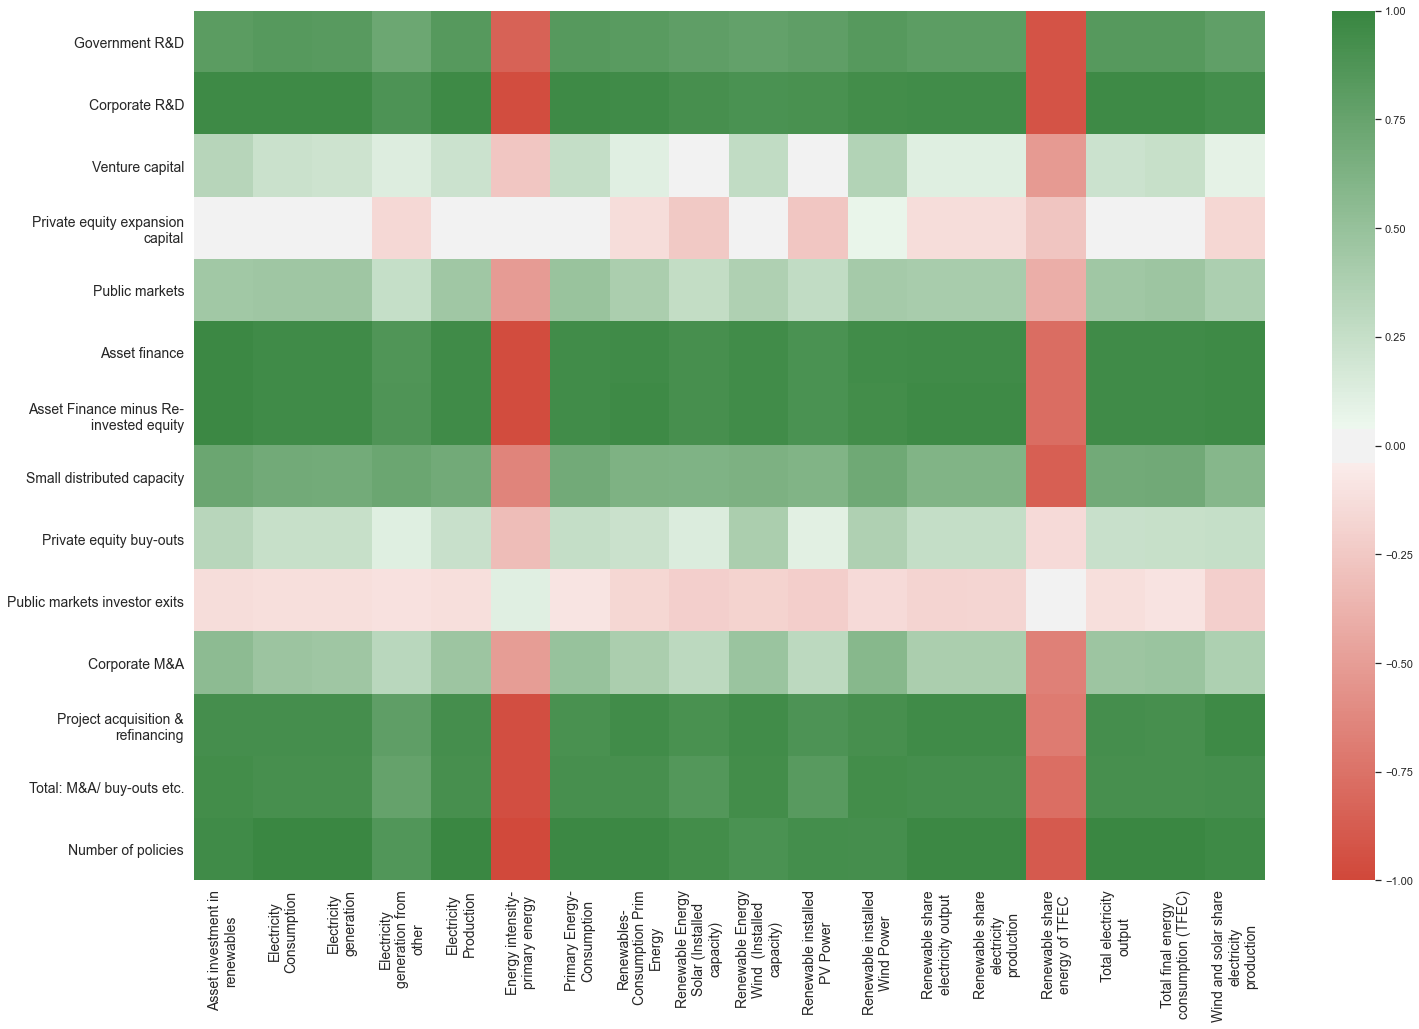

In [7]:
# Generate correlogram data
corr = gen_DF.groupby('Year').sum().corr().loc['f', 'e']

# Generate a custom diverging colormap
cmap_cust = sns.diverging_palette(15, 130, as_cmap=True)

# Generate Correlogram
plt.figure(figsize=(24, 16))
h = sns.heatmap(corr, vmin=-1, vmax=1, annot=False, cmap=cmap_cust)

# Translate Labels and generate convention dictionary
labels_dict, h = redefine_labels (old_fig = h)
# Decided to use manual instead (to show the whole label directly in the figure page)
#h.set_xticklabels(h.get_xticklabels(), ha='right', fontsize=12)
#h.set_yticklabels(h.get_yticklabels(), ha='right', fontsize=12)

# Save the figure
plt.savefig("Comp_Correlogram.jpg")#"resume_correlogram.jpg")

#### Generate Indicator table figure 

In [ ]:
# Print convention table
conventions = pd.DataFrame.from_dict(labels_dict, orient ='index').reset_index()
conventions = conventions.rename(columns={'index':'Indicators', 0:'Convention'})
conventions['Units'] = pd.Series([df_meta['UNIT'][indic] for indic in list(df_meta.index)
             if indic in list(conventions.Indicators)])
conventions['Description'] = pd.Series([textwrap.fill(df_meta['DESCRIPTION'][indic],145) for indic in list(df_meta.index)
             if indic in list(conventions.Indicators)])
fig,ax = ml_table(conventions, header_columns=0, col_w=5.7)
fig.savefig("ind_table.png")